In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import foundation as fd
from foundation import models
from foundation import util

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap
from c3linearize import linearize, class_graph


In [2]:
device = 'cuda'

In [3]:
dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False)
# images = dataset.images
# labels = dataset.labels
# images.shape, labels.shape
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > [Pushed] dataroot: 'C:\\Users\\anwan\\Documents\\workspace\\local_data'
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> ident --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 1118708769 (by default)
|  > din: None (by default)
|  > dout: None (by default)
|  > mode: 'full'
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 2208772859 (by default)
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > load_memory: True (b

480000

In [5]:
factors = dataset.factor_order
factor_sizes = dataset.factor_sizes
factors, factor_sizes

NameError: name 'sizes' is not defined

In [6]:
idx, factor = random.choice(list(enumerate(factors)))
factor 

'orientation'

In [7]:
sz = factor_sizes.copy()
sz.append(1)
sizes = torch.tensor(factor_sizes)
units = torch.from_numpy(np.cumprod(sz[::-1])[-2::-1].copy()).long()

In [8]:
sample = torch.rand(len(sizes)).mul(sizes).long().unsqueeze(0).expand(sizes[idx], len(sizes)).clone()
sample[:,idx] = torch.arange(sizes[idx])
inds = sample.matmul(units.unsqueeze(-1)).squeeze()

In [96]:
inds = torch.randint(len(dataset), size=(128,))

In [97]:
imgs, lbls = dataset[inds]
imgs, lbls = imgs.to(device), lbls.to(device)
imgs.shape, lbls.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128, 6]))

<IPython.core.display.Javascript object>


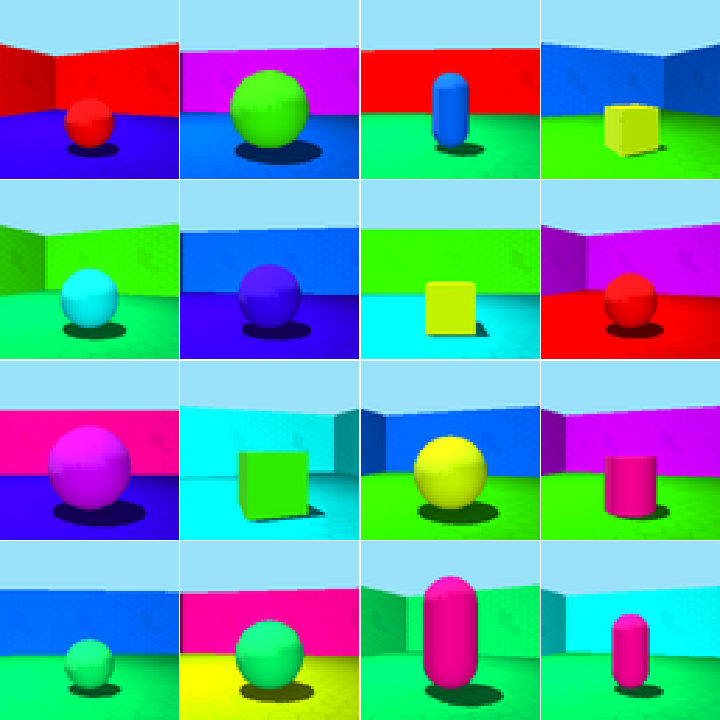

In [98]:
util.show_imgs(imgs[:16])
pass

In [127]:
def viz_mat(M):
    plt.figure()
    plt.matshow(M.cpu(), False)
    eps = 0.03
    plt.subplots_adjust(eps,eps,1-eps,1-eps)
    pass

In [11]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

58

In [12]:
# run_names

In [13]:
name = run_names[7]
# name = random.choice(run_names)
name

'3ds_ae0_e-c12_d-s12_mish_210125-050335'

In [14]:
run = fig.quick_run('load-run', path=name, root=str(root), **{'override.device':device})

| [Pushed] _type: 'run'
| CREATING . (type=run)
|  > silent: False (by default)
|  > invisible: False (by default)
|  > path: '3ds_ae0_e-c12_d-s12_mish_210125-050335'
|  > [Pushed] novel: False
|  > override [dict with 1 item/s]
|  >  > (device): 'cuda'
|  > saveroot --> root: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets'
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_mish_210125-050335\config.yaml
|  > ckpt-num: None (by default)
|  > best: False (by default)
|  > last: True (by default)
|  > [Pushed] dataset._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s12_mish_210125-050335\\ckpt100000'
|  > [Pushed] model._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s12_mish_210125-050335\\ckpt100000'
|  > [Pushed] records._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s12_mish_210125-050335\\ckpt100000'
|  > 

In [15]:
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'strc',
 'dataset_type': '3ds',
 'dec_type': 's12',
 'enc_type': 'c12',
 'extra': 'mish',
 'model_type': 'ae',
 'size': 64}

In [16]:
B = A.pull('dataset.batch_size', 128)
N = 16

In [17]:
# full = run.get_results('eval')
# full.keys()

In [18]:
# X = full['original']
# R = full['reconstruction']
# Q = full['latent']
# X.shape, R.shape, Q.shape

In [19]:
# util.show_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.show_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [20]:
# diff = (X-R).abs().mean(1)
# error = diff.view(B, -1).sum(-1)
# error.shape

In [21]:
# error

In [22]:
model = run.get_model()
model.to(device)
pass

Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), strid

In [99]:
with torch.no_grad():
    recs, qs = model(imgs, ret_q=True)
recs.shape, qs.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128, 12]))

<IPython.core.display.Javascript object>


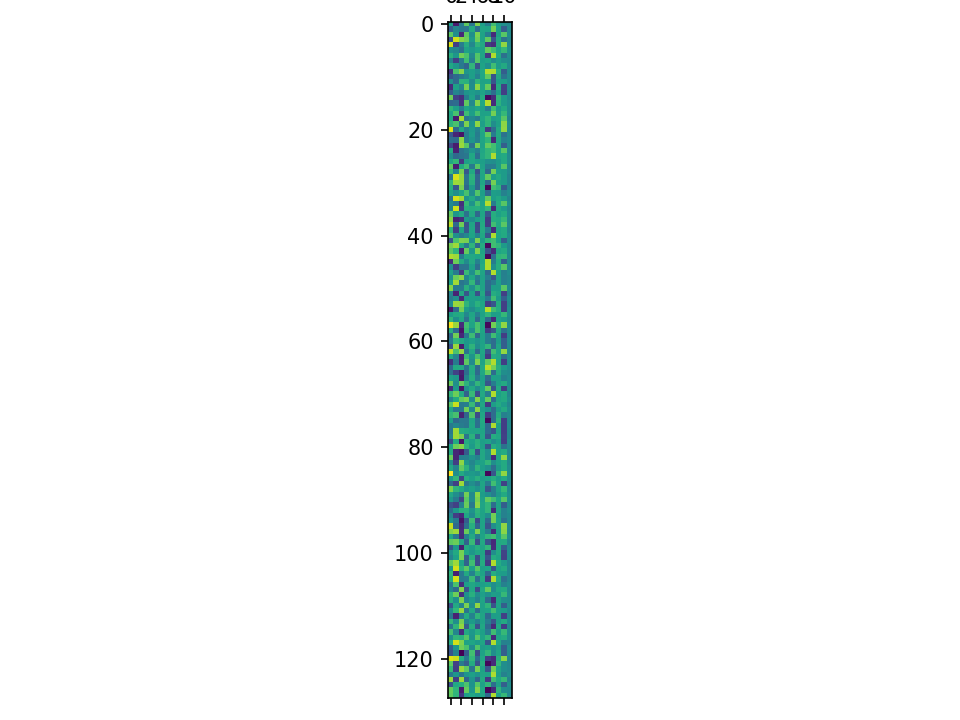

In [100]:
plt.figure()
plt.matshow(qs.cpu(), False)
eps = 0.03
plt.subplots_adjust(eps,eps,1-eps,1-eps)
pass

<IPython.core.display.Javascript object>


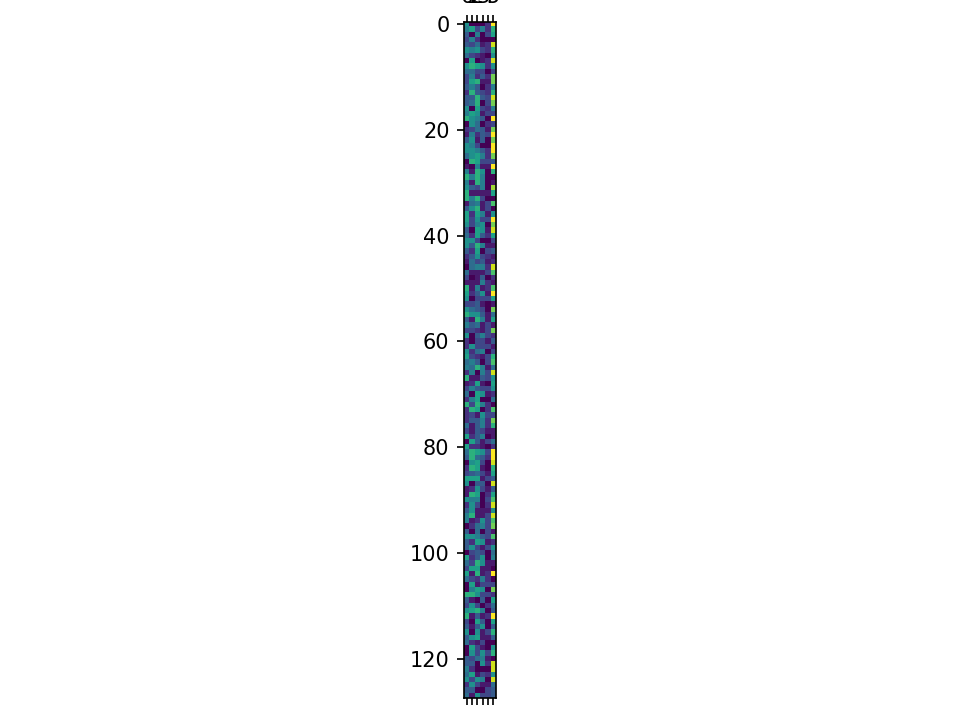

In [101]:
plt.figure()
plt.matshow(lbls.cpu(), False)
eps = 0.03
plt.subplots_adjust(eps,eps,1-eps,1-eps)
pass

In [102]:
def difference(x,y):
    return (x-y).abs().mean(1).view(x.size(0), -1).sum(-1)
def standardize(x):
    x -= x.mean(-1, keepdim=True)
    x /= x.std(-1, keepdim=True)+1e-10
    return x
def normalize(x):
    norm = x.norm(2, -1, keepdim=True)
    return x.div_(norm)

In [103]:
def skyline(imgs):
    im = torch.cat([imgs,imgs[:1]])
    delta = difference(im[1:], im[:-1])
    delta = standardize(delta)
    delta = normalize(delta)
    return delta

In [104]:
sel = 9

In [105]:
gtd = skyline(imgs[:sel])
d = skyline(recs[:sel])
faithfulness = gtd @ d
faithfulness.item()

0.9999907612800598

In [106]:
qs.shape

torch.Size([128, 12])

In [107]:
lbls.shape

torch.Size([128, 6])

In [112]:
# x = normalize(standardize(qs.t()))
# y = normalize(standardize(lbls.float().t())).t()
x = qs.t()
y = lbls.float()
x.shape, y.shape

(torch.Size([12, 128]), torch.Size([128, 6]))

In [113]:
v = normalize(standardize(lbls.float()[:,idx]))
v = y

In [120]:
M = x @ v
M = M.t().abs()

<IPython.core.display.Javascript object>


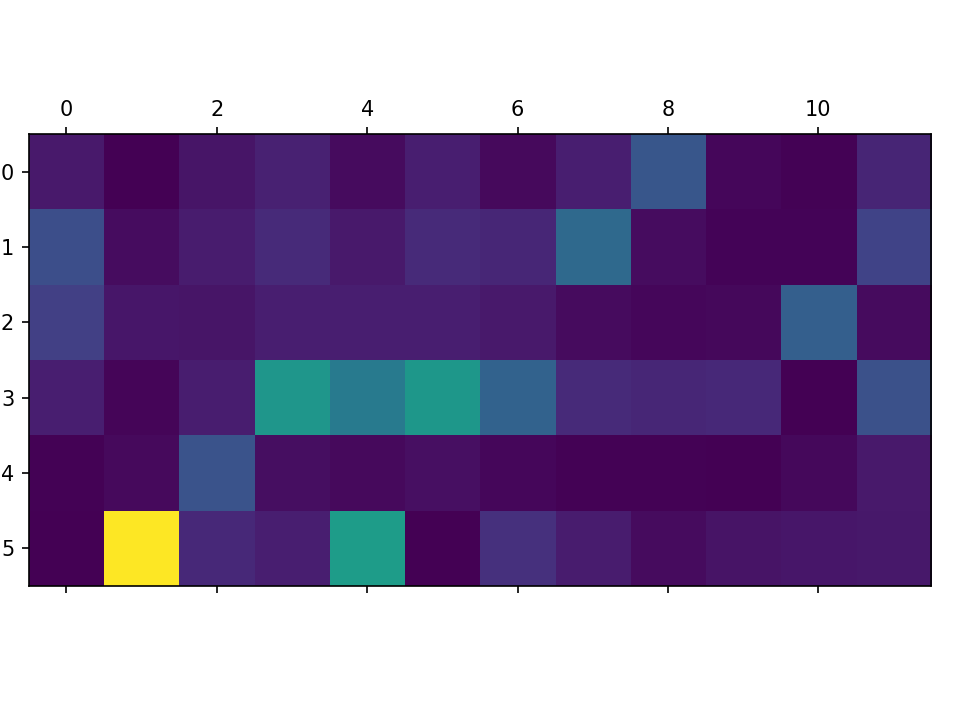

In [121]:
plt.figure()
plt.matshow(M.cpu(), False)
eps = 0.03
plt.subplots_adjust(eps,eps,1-eps,1-eps)
pass

In [128]:
eW = model.encoder.layers[-1][-1].weight
eW.shape

torch.Size([12, 128])

<IPython.core.display.Javascript object>


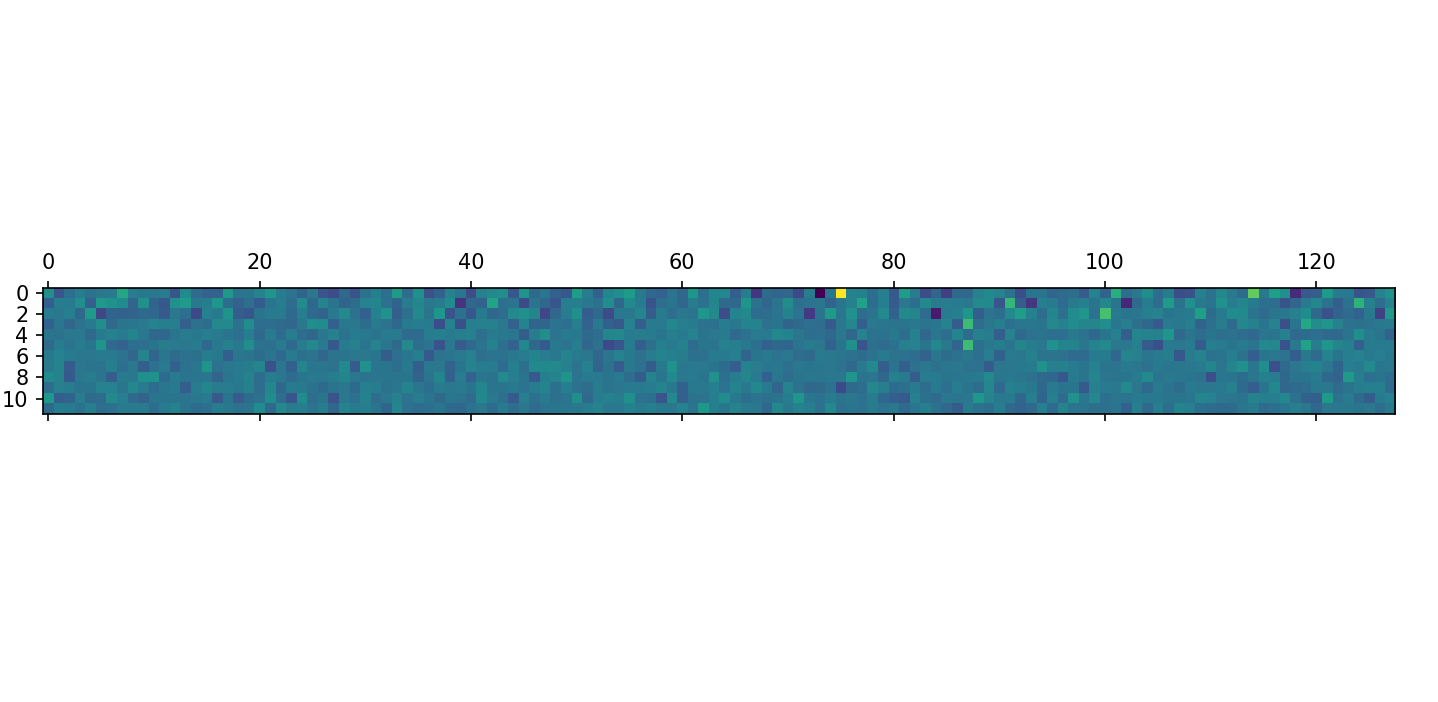

In [130]:
viz_mat(eW.detach())

In [134]:
dW = model.decoder.layers[0].net[0].weight
dW

Parameter containing:
tensor([[-0.0630],
        [ 0.7928],
        [-0.3190],
        [-0.2949],
        [-0.1519],
        [-0.3220],
        [-0.0487],
        [-0.8136],
        [-0.4701],
        [ 0.1700],
        [ 0.6018],
        [-0.0660],
        [ 0.3597],
        [ 0.6281],
        [ 0.7193],
        [ 0.3811],
        [ 0.5398],
        [-0.0611],
        [ 0.0367],
        [ 0.7798],
        [ 0.2457],
        [-0.5617],
        [-0.0254],
        [-0.1724],
        [ 0.0286],
        [-0.8222],
        [-0.1047],
        [-0.8990],
        [ 0.3068],
        [-0.0461],
        [-0.0037],
        [-0.0136],
        [-0.0822],
        [-0.5333],
        [ 0.8478],
        [-0.3410],
        [-0.6992],
        [ 0.5745],
        [ 0.0274],
        [ 0.5876],
        [-0.5246],
        [ 0.0478],
        [ 0.9005],
        [-0.0823],
        [-0.0805],
        [-0.8954],
        [-0.7951],
        [ 0.4615],
        [-0.4480],
        [-0.7983],
        [ 0.7181],
        [